# A polynomial CC-PAP

In this notebook, we solve a toy Principal-Agent-Problem instance (Renner and Schmedders, 2015), explained in (name of the paper).

- In section 1, we solve the PAP for one value of $R_0$, and compare it to the results of Renner and Schmedders
- In section 2, we plot the value of the PAP in function of $R_0$
- In section 3, we adapt the code of section 2 to solve the CC-PAP
- In section 4, we add to the plot of section 2 the values of the CC-PAP for some trust-levels $\alpha$


In [1]:
# imports
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

In this notebook, we optimize in $\mathbb{R}^9$. The correspondance between the dimensions and our objects is the following : if $\texttt{x}$ is a $\texttt{ndarray}$ of shape (9,), then
$$
\begin{cases}
\tilde{w_1} = \texttt{x[0]}\\
\tilde{w_2} = \texttt{x[1]}\\
\tilde{w_3} = \texttt{x[2]}\\
\tilde{a} = \texttt{x[3]}\\
\rho = \texttt{x[4]}\\
n_{00} = \texttt{x[5]}\\
n_{01} = \texttt{x[6]}\\
n_{11} = \texttt{x[7]}\\
m = \texttt{x[8]}
\end{cases}
$$

## 1. Solving the PAP with $R_0 = 0$ 

First, let us define useful functions

$\texttt{minus\_e\_u\_p(x)}$ returns $- \mathbb{E}^{\tilde{a}} [\tilde{U_P}(X,\tilde{w}(X))]$ (to use $\texttt{scipy.optimize.minimize}$)


In [2]:
def minus_e_u_p(x):

    """
    Utility function of the agent for eta = 1/2
    """
    
    w1 = x[0]**2
    w2 = x[1]**2
    w3 = x[2]**2
    a_t = x[3]  #\tilde{a}
    
    res = 2 + 2*a_t - w1/4 + a_t*w1/2 - a_t**2*w1 / 4 - w2/2
    res += a_t**2*w2/2 - w3/4 - a_t*w3/2 - a_t**2*w3/4 

    return - res

$\texttt{e\_u\_a(x)}$ returns $\mathbb{E}^{\tilde{a}} [\tilde{U_A}(\tilde{w}(X),\tilde{a})]$

In [3]:
def e_u_a(x):

    res = 0
    w1_t = x[0]
    w2_t = x[1]
    w3_t = x[2]
    a = x[3]

    res += -5/2 + w1_t/2 + w2_t + w3_t/2 - a - a*w1_t
    res += a*w3_t - a**2*w2_t + a**2*w1_t/2 - a**2/2 + a**2*w3_t/2

    return res 

In [4]:
# fixing hyperparameters

R0 = 0

Then, we define the $\texttt{bounds}$ object that will be given as argument to $\texttt{scipy.optimize.minimize}$

In [5]:
# bounds

bounds = sp.optimize.Bounds(lb = [0,0,0,-1,-np.inf,0,-np.inf,0,0], 
                            ub=[np.inf,np.inf,np.inf,1,np.inf,np.inf,np.inf,np.inf,np.inf])

Now, let us define our constraints
- constraint 1 ensures that $\rho = - \mathbb{E}^{\tilde{a}} [\tilde{U_A}(\tilde{w}(X),\tilde{a})]$
- constraint 2 ensures that $\mathrm{det}\, n \geq 0$
- constraint 3,4,5 ensures that the polynomials $- \mathbb{E}^{\tilde{a}} [\tilde{U_A}(\tilde{w}(X),\tilde{a})] - \rho$ and $\begin{pmatrix} 1 & a \end{pmatrix} n \begin{pmatrix} 1 \\ a \end{pmatrix} + (1 - a^2) m$ have the same coefficients

In [6]:
# constraint 1

non_linear_equality_consts = []

non_linear_equality_consts.append(sp.optimize.NonlinearConstraint(
    fun = lambda x:x[4] + e_u_a(x),
    lb = [0],
    ub = [0]
))

In [7]:
# constraint 2

non_linear_inequality_consts = []

non_linear_inequality_consts.append(sp.optimize.NonlinearConstraint(
    fun = lambda x:x[5]*x[7] - x[6]**2,
    lb = [0],
    ub = [np.inf]
))

In [8]:
# constraints 3-5

linear_equality_consts = []

lconst_eq_mat = np.array([
    [1/2, 1, 1/2, 0, 1, 1, 0, 0, 1],
    [-1, 0, 1, 0, 0, 0, 2, 0, 0],
    [1/2, -1, 1/2, 0, 0, 0, 0, 1, -1],
])

linear_equality_consts.append(sp.optimize.LinearConstraint(
    A = lconst_eq_mat,
    lb = [5/2,1,1/2],
    ub = [5/2,1,1/2]
))

We have now defined all constraints common to the PAP and the CC-PAP. Now, let us define the esperance constraint

In [9]:
common_constraints = non_linear_equality_consts + non_linear_inequality_consts + linear_equality_consts

In [10]:
# average rationality constraint

ineq_const_rational_avg_mat = np.array([0, 0, 0, 0, -1, 0, 0, 0, 0])
ineq_const_rational_avg = sp.optimize.LinearConstraint(
    A = ineq_const_rational_avg_mat,
    lb = [R0],
    ub = [np.inf]
)

### First solving

Let us solve the PAP, with naïve initial conditions, perturbed by a $\mathcal{N}(0,1)$. 

In [11]:
init = np.array([
    0, 0, 0, 0, 0, 1, 0, 1, 1 
])

res = sp.optimize.minimize(fun = minus_e_u_p,method="SLSQP",
                           x0 = init + np.random.randn() ,
                           constraints=common_constraints+[ineq_const_rational_avg],bounds=bounds,
                           options={"disp":False})

print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.38433702731759434
       x: [ 5.866e-01  1.224e+00  1.879e+00  2.975e-01  1.812e-13
            4.341e-02 -1.460e-01  4.913e-01  6.001e-15]
     nit: 58
     jac: [ 1.448e-01  1.116e+00  1.581e+00 -2.767e-01  0.000e+00
            0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 656
    njev: 58


Now, let us display the value of each parameter.

In [12]:
print(-res.fun)
print()
print(f"w1* = {res.x[0]**2}")
print(f"w2* = {res.x[1]**2}")
print(f"w3* = {res.x[2]**2}")
print(f"a = {(res.x[3]+1)/2}")
print(f"rho = {res.x[4]}")
print(f"n00 = {res.x[5]}, n01 = {res.x[6]}, n11 = {res.x[7]}")
print(f"m00 = {res.x[8]}")

0.38433702731759434

w1* = 0.3441259182833757
w2* = 1.498000710096123
w3* = 3.5295025823875443
a = 0.6487286048689394
rho = 1.812377246997085e-13
n00 = 0.04341185226231572, n01 = -0.14603728861617532, n11 = 0.4912686373673603
m00 = 6.000770193248517e-15


The objective function is the same magnitude order as the value found by Renner and Schmedders, but it is not very satisfactory. 

To avoid local minima, let us repeatedly solve the same problem with random initial conditions, and keep the best result.

### Second solving

In [13]:
init = np.array([
    0, 0, 0, 0, 0, 1, 0, 1, 1 
])

best_res = None
best_obj_func = -np.inf

for _ in range(5):
    res = sp.optimize.minimize(fun = minus_e_u_p,method="SLSQP",
                           x0 = init + np.random.randn() ,
                           constraints=common_constraints+[ineq_const_rational_avg],bounds=bounds,
                           options={"disp":False})
    if -res.fun > best_obj_func:
        best_res = res

print(best_res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.38370120872542324
       x: [ 5.541e-01  1.254e+00  1.856e+00  2.751e-01  1.450e-09
            4.150e-02 -1.509e-01  5.485e-01  1.807e-09]
     nit: 53
     jac: [ 1.456e-01  1.159e+00  1.509e+00 -3.477e-01  0.000e+00
            0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 613
    njev: 53


Now, let us display the value of each parameter.

In [14]:
print(-res.fun)
print()
print(f"w1* = {res.x[0]**2}")
print(f"w2* = {res.x[1]**2}")
print(f"w3* = {res.x[2]**2}")
print(f"a = {(res.x[3]+1)/2}")
print(f"rho = {res.x[4]}")
print(f"n00 = {res.x[5]}, n01 = {res.x[6]}, n11 = {res.x[7]}")
print(f"m00 = {res.x[8]}")

0.38370120872542324

w1* = 0.3070350832014302
w2* = 1.57129846246931
w3* = 3.4442278724344373
a = 0.6375543284746268
rho = 1.449718762506868e-09
n00 = 0.041500273152983644, n01 = -0.1508778208735759, n11 = 0.5485291528692434
m00 = 1.8068598555491104e-09


The objective function value is very close from the value found by Renner and Schmedders (the difference between is less than $0.001$), and the parameters are close as well. This resolution can be considered satisfactory.

### Third solving : trying a global optimizer

In [15]:
res = sp.optimize.shgo(func = minus_e_u_p,
                           constraints=common_constraints+[ineq_const_rational_avg],bounds=bounds,
                           options={"disp":True})

print(res)

 message: Failed to find a feasible minimizer point. Lowest sampling point = 1.0000000000000002e+100
 success: False
     fun: 1.0000000000000002e+100
       x: [ 1.000e+50  0.000e+00  0.000e+00 -1.000e+00 -1.000e+50
            1.000e+50  1.000e+50  1.000e+50  0.000e+00]
     nit: 1
    nfev: 12
   nlfev: 0
   nljev: 0
   nlhev: 0
    tnev: 513


Well, it does not seem to work. We will keep using repeated local minimizers

## 2. Multiple solvings of the PAP, varying $R_0$

Let us define some additional constraints, which enforce
$$
\tilde{w_1} \, < \, \tilde{w_2} \, < \, \tilde{w_3}
$$

In [16]:
monotony_const_mat = np.array([
    [-1,1,0,0,0,0,0,0,0],
    [0,-1,1,0,0,0,0,0,0],
])

monotony_const = sp.optimize.LinearConstraint(
    A = monotony_const_mat,
    lb = [1e-6,1e-6],
    ub = [np.inf,np.inf]
)

Let us write a function that solves the PAP, to perform multiple solutions with different $R_0$ values.

In [17]:
def pap_R0(loc_R0=0, verbose=False, loc_init=np.array([0, 0, 0, 0, 0, 1, 0, 1, 1 ]),ntest=8,ordered_w=False):
    
    # we define the esperance >= R0 constraint

    const_mat = np.array([0, 0, 0, 0, -1, 0, 0, 0, 0])
    const = sp.optimize.LinearConstraint(
        A = const_mat,
        lb = [loc_R0],
        ub = [np.inf]
    )

    constraints = common_constraints + [const]

    # this argument allows to see if the solution changes when the monotony is imposed

    if ordered_w:
        constraints.append(monotony_const)

    if verbose:
        print(f"PAP solving, R_0 = {loc_R0}")

    # multiple solutions

    current_res = sp.optimize.minimize(fun = minus_e_u_p, x0 = loc_init+np.random.randn(9), 
                               method="SLSQP",
                               constraints=constraints,bounds=bounds,
                               options={"disp":verbose})
    current_val = -np.inf
    if current_res.status == 0:
        current_val = - current_res.fun
    
    for _ in range(ntest-1):
        loc_res = sp.optimize.minimize(fun = minus_e_u_p, x0 = loc_init+np.random.randn(9), 
                               method="SLSQP",
                               constraints=constraints,bounds=bounds,
                               options={"disp":False})
        if loc_res.status == 0 and -loc_res.fun > current_val:
            current_val = -loc_res.fun
            current_res = loc_res

    if verbose:
        print(res)
        print(f"Utility = {-current_val}")
        print()
    
    return current_res

To test the function, let us try it with $R_0 = 0$

In [18]:
res = pap_R0(verbose=False)
print(res)
print(-res.fun)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.38467817990575126
       x: [ 5.939e-01  1.226e+00  1.875e+00  2.867e-01 -2.818e-14
            4.006e-02 -1.403e-01  4.915e-01  3.711e-15]
     nit: 25
     jac: [ 1.512e-01  1.125e+00  1.551e+00 -2.960e-01  0.000e+00
            0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 267
    njev: 25
0.38467817990575126


We obtain the same result as in the previous part, which is an argument for the well-working of this function.

Now, let us run repeatedly this function for different values of $R_0$

### General plot

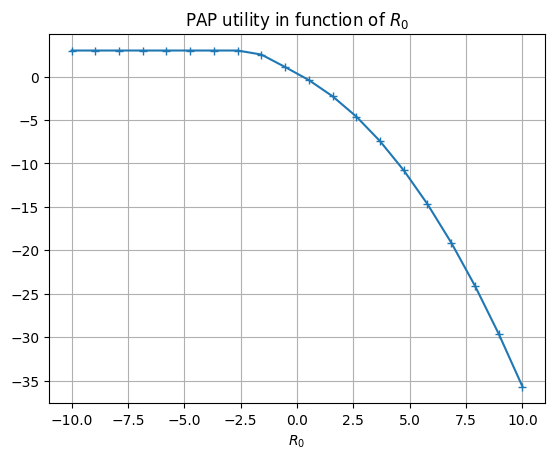

In [19]:
R0_list = np.linspace(-10,10,20)
utility_list = [-pap_R0(loc_R0=r).fun for r in R0_list]

plt.title("PAP utility in function of $R_0$")
plt.plot(R0_list,utility_list,marker="+")
plt.xlabel("$R_0$")
plt.grid()
plt.show()

Firstly, the utility function is decreasing, which is coherent.

It seems that there are two limit behaviors :
- with $|R_0| >> 1$ and $R_0 < 0$, the utility function seems roughly constant and equal to 3
- with $|R_0| >> 1$ and $R_0 > 0$, the utility function is decreasing, and roughly looks like a parabole

### Low $R_0$ plot

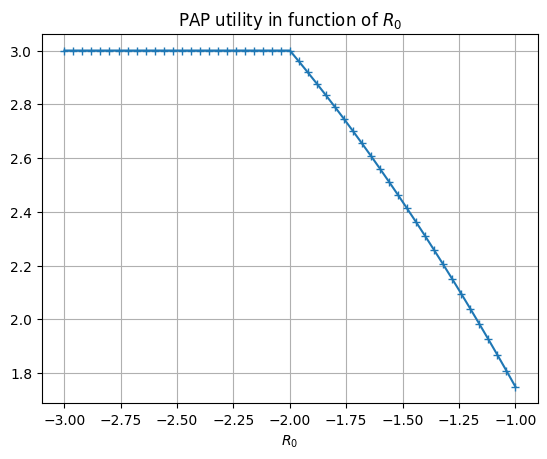

In [20]:
R0_list = np.linspace(-3,-1,51)
utility_list = [-pap_R0(loc_R0=r).fun for r in R0_list]

plt.title("PAP utility in function of $R_0$")
plt.plot(R0_list,utility_list,marker="+")
plt.xlabel("$R_0$")
plt.grid()
plt.show()

In [21]:
low_r0_res = pap_R0(loc_R0=-5)

print(f"w = ({low_r0_res.x[0]**2:.3f}, {low_r0_res.x[1]**2:.3f}, {low_r0_res.x[2]**2:.3f})")
print(f"a = {low_r0_res.x[3]:.3f}")

w = (0.000, 0.000, 1.000)
a = 1.000


It seems that the utility is constant and equal to 3 for $R_0 \leq -2$. This comes from the fact that the relaxed PAP (without the constraint $\mathbb{E}^{\tilde{a}} [\tilde{U_A}(\tilde{w}(X),\tilde{a})]\geq R_0$) has a solution, feasible for $R_0 \leq -2$. In this point, the value of the objective function is $3$

The next cell numerically solves this relaxed problem, and reaches the optimum (an objective function value equal to 3)

In [22]:
# limit case optimization

limit_case_mat = np.array([
    [1,-2,1,0],
    [1,-1,0,0]
])

limit_case_const = sp.optimize.LinearConstraint(
    A = limit_case_mat,
    lb = [1,0],
    ub = [1,0]
)

init = np.array([
    1, 1, 2, 0
])

limit_bounds = sp.optimize.Bounds(lb = [0,0,0,-1], ub=[np.inf,np.inf,np.inf,1])

res = sp.optimize.minimize(fun = minus_e_u_p, x0 = init,method="SLSQP",
                           constraints=[limit_case_const],bounds=limit_bounds,
                           options={"disp":True})

print(-res.fun)
print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.99999999999999
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 3
2.99999999999999
[3.27515792e-15 3.27515792e-15 1.00000000e+00 1.00000000e+00]


### High $R_0$

Now, let us zoom on the part of the curve with high $R_0$ values. Intuitively, this curve seems parabolic. To try that out, let us fit the curve with polynomials of degree 2.

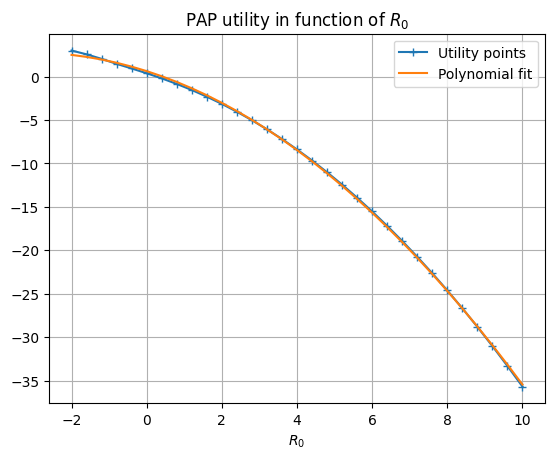

[-0.22278772 -1.37981087  0.62909648]


In [23]:
R0_list = np.linspace(-2,10,31)
utility_list = [-pap_R0(loc_R0=r).fun for r in R0_list]
coeff_poly = np.polyfit(R0_list,utility_list,2)

plt.title("PAP utility in function of $R_0$")
plt.plot(R0_list,utility_list,marker="+",label="Utility points")
plt.plot(R0_list,np.poly1d(coeff_poly)(R0_list),label="Polynomial fit")
plt.xlabel("$R_0$")
plt.grid()
plt.legend()
plt.show()

print(coeff_poly)

Now, let us repeat the fit, with another range of $R_0$ values

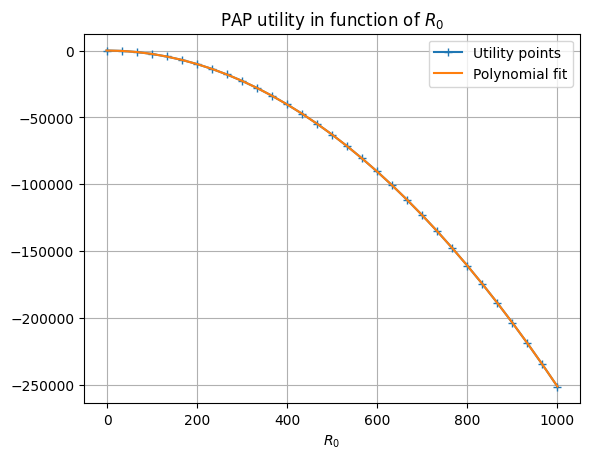

[-0.24999743 -1.00314553 -0.19031276]


In [24]:
R0_list = np.linspace(-2,1000,31)
utility_list = [-pap_R0(loc_R0=r).fun for r in R0_list]
coeff_poly = np.polyfit(R0_list,utility_list,2)

plt.title("PAP utility in function of $R_0$")
plt.plot(R0_list,utility_list,marker="+",label="Utility points")
plt.plot(R0_list,np.poly1d(coeff_poly)(R0_list),label="Polynomial fit")
plt.xlabel("$R_0$")
plt.grid()
plt.legend()
plt.show()

print(coeff_poly)

The coefficients have very similar values, which means, that asymptotically, the value of the PAP seems "equivalent" to $-\frac{1}{4} (R_0)^2$. However, we have not succeeded in proving that conjecture.

## 3. Solving the CC-PAP with $R_0 = 0$

Now, let us write a function solving the PAP. As presented in the paper, the function is quite similar to the PAP, but adding constraints. 

To manage all combinations of variables $2 (\tilde{w_i} - 1 - a^2) \geq R_0$, we will write $i \in [\![1,7]\!]$ in base 2 : the lowest digit is the truth value of $2 (\tilde{w_1} - 1 - a^2) \geq R_0$, the middle digit of $2 (\tilde{w_2} - 1 - a^2) \geq R_0$ and the highest digit of $2 (\tilde{w_3} - 1 - a^2) \geq R_0$

An optional argument of the function authorizes to add the monotony constraint : the problem which is solved is therefore the _ethical CC-PAP_, as defined in the paper.

In [25]:
def cc_pap(alpha=0.05,verbose=False,R1=0,ntest=8,increasing_w=False):

    init = np.array([
        0, 0, 0, 0, 0, 1, 0, 1, 1 
    ])

    # defining constraints

    region_constraint_list = []
    for i in range(2):
        for j in range(2):
            for k in range(2):

                increase_check = ((i <= j) or not(increasing_w)) and ((j <= k) or not(increasing_w))
                if ((i == 1) or (j == 1) or (k == 1)) and increase_check:

                    region_constraint_list.append(sp.optimize.NonlinearConstraint(
                        fun = lambda x,i=i,j=j,k=k : (
                            -(-1)**i * (2 * (x[0] - 1 - (1+x[3])**2/4) - R1),
                            -(-1)**j * (2 * (x[1] - 1 - (1+x[3])**2/4) - R1),
                            -(-1)**k * (2 * (x[2] - 1 - (1+x[3])**2/4) - R1),
                            i * (1-x[3])**2/4 + j * (1+x[3])*(1-x[3])/2 + k * (1+x[3])**2/4 - (1 - alpha)
                                                      ),
                        lb = [0,0,0,0],
                        ub = [np.inf,np.inf,np.inf,np.inf]
                    ))
     

    res_list = []

    imax = -1
    for i in range(len(region_constraint_list)):

        # solving subproblem i

        constraints = common_constraints+[region_constraint_list[i]]
        if increasing_w:
            constraints += [monotony_const]

        if verbose:
            print(f"Region {i+1}")

        # to avoid local minima, we solve ntest times each subproblem 

        best_res = None
        best_val = -np.inf

        for _ in range(ntest):
            res = sp.optimize.minimize(fun = minus_e_u_p, x0 = init+np.random.randn(9),
                                        method="SLSQP",constraints=constraints,
                                        bounds=bounds,options={"disp":False})
            if res.status == 0 and -res.fun > best_val:
                best_res = res
                best_val = -res.fun
        
        # keeping the best solution for the subproblem, among the succesful solvings
        
        if best_val > -np.inf:
            res_list.append(best_res)

    # here, we check if any subproblem was successfully solved

    if len(res_list) == 0:
        return None
    else:
        obj_fun_list = [-res.fun for res in res_list]
        imax = obj_fun_list.index(max(obj_fun_list))
        return res_list[imax]

### Testing `cc_pap`

First, let us choose $\alpha = 0$, $R_0 = -2$, and try `cc_pap` with `increasing_w=False` and `increasing_w=True` , to see if we recover the relaxed problem solution

In [26]:
res = cc_pap(alpha=0,verbose=True,R1=-2)

print()
print("Solution of the CC-PAP")
print(-res.fun)
print(f"w1* = {res.x[0]**2}")
print(f"w2* = {res.x[1]**2}")
print(f"w3* = {res.x[2]**2}")
print(f"a = {(res.x[3]+1)/2}")
print(f"rho = {res.x[4]}")
print(f"n00 = {res.x[5]}, n01 = {res.x[6]}, n11 = {res.x[7]}")
print(f"m00 = {res.x[8]}")

Region 1
Region 2
Region 3
Region 4
Region 5
Region 6
Region 7

Solution of the CC-PAP
3.0000000000000067
w1* = 0.0
w2* = 0.0
w3* = 0.9999999999999933
a = 1.0
rho = 2.000000000000005
n00 = 0.0, n01 = 1.3877787807814457e-15, n11 = 3.5388358909926865e-16
m00 = 0.0


In [27]:
res = cc_pap(alpha=0,verbose=True,R1=-2,increasing_w=True)

print()
print("Solution of the ethical CC-PAP")
print(-res.fun)
print(f"w1* = {res.x[0]**2}")
print(f"w2* = {res.x[1]**2}")
print(f"w3* = {res.x[2]**2}")
print(f"a = {(res.x[3]+1)/2}")
print(f"rho = {res.x[4]}")
print(f"n00 = {res.x[5]}, n01 = {res.x[6]}, n11 = {res.x[7]}")
print(f"m00 = {res.x[8]}")

Region 1
Region 2
Region 3

Solution of the ethical CC-PAP
2.9999986666672163
w1* = 0.0
w2* = 9.999990619747866e-13
w3* = 1.0000013333327837
a = 1.0
rho = 1.9999986666676608
n00 = 3.1337432648825825e-13, n01 = -3.333336310445967e-07, n11 = 6.666669487565002e-07
m00 = 0.0


In [28]:
res = pap_R0(-2,verbose=False)

print()
print("Solution of the PAP")
print(-res.fun)
print(f"w1* = {res.x[0]**2}")
print(f"w2* = {res.x[1]**2}")
print(f"w3* = {res.x[2]**2}")
print(f"a = {(res.x[3]+1)/2}")
print(f"rho = {res.x[4]}")
print(f"n00 = {res.x[5]}, n01 = {res.x[6]}, n11 = {res.x[7]}")
print(f"m00 = {res.x[8]}")


Solution of the PAP
3.000000000002644
w1* = 0.0
w2* = 0.0
w3* = 0.9999999999973559
a = 1.0
rho = 2.000000000002644
n00 = 0.0, n01 = 4.095574960172755e-13, n11 = 0.0
m00 = 1.3676313090964053e-13


We recover the solution of $(P_r)$. In addition, the optimal wage of the CC-PAP is increasing, and the ethical CC-PAP returns the same solution as the CC-PAP. Both facts are encouraging relative to the correctness of `cc_pap`

## 4. Solving the PAP, the CC-PAP and the ethical PAP for different values of $\alpha$ and $R_0$

### Fixed $R_0$

First, let us compute the value of the CC-PAP and the ethical CC-PAP for a fixed $R_0$ value (here $R_0 = -1$) and different values of $\alpha$

In [29]:
alpha_list_x = [1e-3,5e-3,1e-2,5e-2] + list(np.linspace(0.1,0.9,10))
cc_pap_res_list = [cc_pap(alpha=alpha,R1=-1,increasing_w=False) for alpha in alpha_list_x]
ethical_cc_pap_res_list = [cc_pap(alpha=alpha,R1=-1,increasing_w=True) for alpha in alpha_list_x]

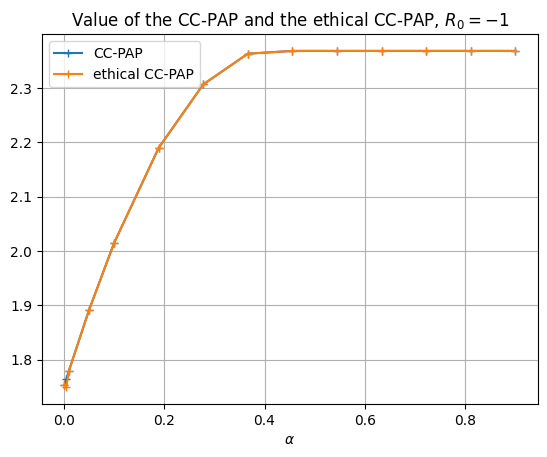

In [30]:
plt.title("Value of the CC-PAP and the ethical CC-PAP, $R_0 = -1$")

plt.plot(alpha_list_x,[-res.fun for res in cc_pap_res_list ],marker="+",label = "CC-PAP")
plt.plot(alpha_list_x,[-res.fun for res in ethical_cc_pap_res_list ],marker="+",label = "ethical CC-PAP")

plt.xlabel("$\\alpha$")

plt.legend()
plt.grid()
plt.show()

We can notice that
1. The value of both problems is an increasing function of $\alpha$, which is expected, because the function $\alpha \mapsto \text{Feasible set of the CC-PAP of parameter } \alpha$ is increasing
2. Both problems seem to have the same value on this range ! Let us check is the optimal points are the same

In [31]:
for i in range(len(alpha_list_x)):

    x1 = cc_pap_res_list[i].x
    x2 = ethical_cc_pap_res_list[i].x

    x_difference = np.linalg.norm(x1 - x2) / np.linalg.norm(x1)
    f_x_difference = np.linalg.norm(minus_e_u_p(x1) - minus_e_u_p(x2)) / np.linalg.norm(minus_e_u_p(x1))
    
    print(alpha_list_x[i])
    print(x_difference)
    print(f_x_difference)
    print()

0.001
0.0017117132533556742
1.0981262384372283e-06

0.005
0.37516053032006363
0.008447947032188255

0.01
0.029413498152073683
9.411122847008074e-07

0.05
7.420438408555921e-05
1.6992259614548019e-06

0.1
0.0002910625007563477
7.078013991279835e-06

0.18888888888888888
0.0002031962746549473
1.2436623200063346e-05

0.2777777777777778
9.878853677047891e-06
4.0495559430004464e-07

0.3666666666666667
1.1635660768897224e-05
4.094063107657676e-07

0.4555555555555556
2.053091579215928e-05
3.1155261851239846e-08

0.5444444444444445
1.6138579701689647e-05
4.666223335514429e-07

0.6333333333333333
7.520355601398109e-05
8.132159326402617e-09

0.7222222222222222
1.3594652181352069e-05
2.3391907737364146e-08

0.8111111111111111
0.00020525532038570053
9.968049180301979e-09

0.9
2.646918813629931e-05
4.4387767685294816e-07



The values of the objective functions for both problems are very close, and the optimal points are also very close. 

This is why in the other plots, we will only optimize the CC-PAP, and check whether the optimal wage is increasing (which means that, apart from numerical errors, this is also the optimal wage for the ethical CC-PAP)

### Low $R_0$

In [32]:
R0_list = np.linspace(-4,4,10)
pap_res_list = [pap_R0(loc_R0=r) for r in R0_list]

alpha_list = [1e-3,1e-2,5e-2,1e-1,2e-1,5e-1,1]
cc_pap_res_mat = [[cc_pap(alpha=a,R1=r) for a in alpha_list] for r in R0_list]

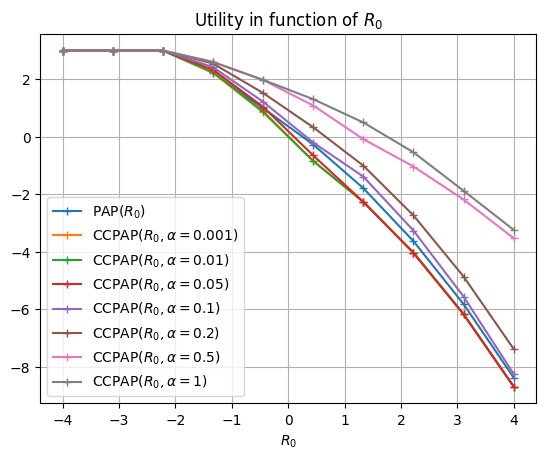

In [33]:
cc_pap_fun_mat = np.array([[ -cc_pap_res_mat[i][j].fun
    for j in range(len(alpha_list))] 
    for i in range(len(R0_list))])

pap_fun_list = [-res.fun for res in pap_res_list]

labels = [f"CCPAP$(R_0,\\alpha={a})$" for a in alpha_list]

plt.title("Utility in function of $R_0$")
plt.plot(R0_list,pap_fun_list,marker="+",label="PAP$(R_0)$")
plt.plot(np.array(R0_list),cc_pap_fun_mat,marker="+",label=labels)
plt.xlabel("$R_0$")
plt.legend()
plt.grid()
plt.show()

The maximal utility is a decreasing function of $R_0$ for the PAP and the CC-PAP, and an increasing function of $\alpha$ for the CC-PAP, which is consistent with the theory.

Now, let us check the monotony of the optimal wages of the CC-PAP.

In [34]:
def check_increase(x):
    
    w1_t = x[0]
    w2_t = x[1]
    w3_t = x[2]

    increment_1 = (w2_t - w1_t) / np.abs(w2_t)
    increment_2 = (w3_t - w2_t) / np.abs(w3_t)

    return increment_1,increment_2

In [35]:
for i in range(len(R0_list)):
    for j in range(len(alpha_list)):
        d1,d2 = check_increase(cc_pap_res_mat[i][j].x)
        if (d1 < -1e-4) or (d2 < -1e-4):
            print(f"R0 = {R0_list[i]}, alpha = {alpha_list[j]}")
            print(f"w1_t = {cc_pap_res_mat[i][j].x[0]}")
            print(f"w2_t = {cc_pap_res_mat[i][j].x[1]}")
            print(f"w3_t = {cc_pap_res_mat[i][j].x[2]}")
            print()

R0 = -4.0, alpha = 0.001
w1_t = 1.934462532074002e-15
w2_t = 0.0
w3_t = 0.9999999999999407

R0 = -4.0, alpha = 0.01
w1_t = 1.7657533421533422e-14
w2_t = 0.0
w3_t = 0.9999999999997237

R0 = -2.2222222222222223, alpha = 0.5
w1_t = 3.1575198185251896e-13
w2_t = 0.0
w3_t = 0.9999999999980351

R0 = -1.3333333333333335, alpha = 0.01
w1_t = 0.3233261870988037
w2_t = 0.32297513962979124
w3_t = 1.3233333333333313

R0 = -1.3333333333333335, alpha = 0.05
w1_t = 0.2833273897401733
w2_t = 0.283273202578399
w3_t = 1.2833333333333332

R0 = -1.3333333333333335, alpha = 0.2
w1_t = 0.13327419806536736
w2_t = 0.13326008181568655
w3_t = 1.1333333333333326

R0 = -1.3333333333333335, alpha = 0.5
w1_t = 0.014752254668881538
w2_t = 0.014660915935558929
w3_t = 1.0148971641517497

R0 = -1.3333333333333335, alpha = 1
w1_t = 0.014728826535172367
w2_t = 0.014618765159310208
w3_t = 1.0149034417642808

R0 = -0.44444444444444464, alpha = 0.001
w1_t = 0.7687199552642647
w2_t = 0.7644263511375652
w3_t = 1.7767778611455

/tmp/ipykernel_23354/1630764533.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  increment_1 = (w2_t - w1_t) / np.abs(w2_t)
/tmp/ipykernel_23354/1630764533.py:7: RuntimeWarning: invalid value encountered in scalar divide
  increment_1 = (w2_t - w1_t) / np.abs(w2_t)


We can see that the optimal wages of the CC-PAP are increasing for these values of $R_0$ and $\alpha \leq 0.1$. However, for $\alpha \in \{0.5,1\}$, some optimal salaries are not monotonous, when $R_0 \geq 1.3$.

To check this result, let us solve the PAP, CC-PAP and the ethical CC-PAP for $R_0 = 2$, and $\alpha = 0.5$

In [36]:
res = cc_pap(alpha=0.5,verbose=True,R1=2)

print()
print("Solution of the CC-PAP")
print(-res.fun)
print(f"w1* = {res.x[0]**2}")
print(f"w2* = {res.x[1]**2}")
print(f"w3* = {res.x[2]**2}")
print(f"a = {(res.x[3]+1)/2}")
print(f"rho = {res.x[4]}")
print(f"n00 = {res.x[5]}, n01 = {res.x[6]}, n11 = {res.x[7]}")
print(f"m00 = {res.x[8]}")

Region 1
Region 2
Region 3
Region 4
Region 5
Region 6
Region 7

Solution of the CC-PAP
-0.7808476466311749
w1* = 1.0677997890473241e-08
w2* = 5.062343687225799
w3* = 0.9982814052284488
a = 0.499964866691153
rho = -0.24958709735047746
n00 = 7.694420784401039e-08, n01 = 0.0004815006488716055, n11 = 2.2503433529072563
m00 = 0.0


In [37]:
res = cc_pap(alpha=0.5,verbose=True,R1=2,increasing_w=True)

print()
print("Solution of the ethical CC-PAP")
print(-res.fun)
print(f"w1* = {res.x[0]**2}")
print(f"w2* = {res.x[1]**2}")
print(f"w3* = {res.x[2]**2}")
print(f"a = {(res.x[3]+1)/2}")
print(f"rho = {res.x[4]}")
print(f"n00 = {res.x[5]}, n01 = {res.x[6]}, n11 = {res.x[7]}")
print(f"m00 = {res.x[8]}")

Region 1
Region 2
Region 3

Solution of the ethical CC-PAP
-1.421568947997378
w1* = 2.2499896602099065
w2* = 2.249992660205039
w3* = 6.24999999999988
a = 0.7071067811865498
rho = -0.9999973818267128
n00 = 2.7269136717679454e-07, n01 = -1.723300316660891e-06, n11 = 5.557363284936177e-07
m00 = 1.2790362402963242e-06


In [38]:
res = pap_R0(2,verbose=False)

print()
print("Solution of the PAP")
print(-res.fun)
print(f"w1* = {res.x[0]**2}")
print(f"w2* = {res.x[1]**2}")
print(f"w3* = {res.x[2]**2}")
print(f"a = {(res.x[3]+1)/2}")
print(f"rho = {res.x[4]}")
print(f"n00 = {res.x[5]}, n01 = {res.x[6]}, n11 = {res.x[7]}")
print(f"m00 = {res.x[8]}")


Solution of the PAP
-3.141962373521231
w1* = 3.3594624606341066
w2* = 5.02537697119711
w3* = 7.024237717799357
a = 0.4087821031806261
rho = -2.000000000002221
n00 = 0.016658992435655526, n01 = 0.0912778976160479, n11 = 0.5001295103295349
m00 = 3.4447574729519284e-12


We have found another example of increasing wages for the PAP, and non monotonous for the CC-PAP (for some $\alpha \in ]0,1[$). From that point on, we will therefore study the CC-PAP and the ethical CC-PAP.

In [39]:
alpha_list_2 = [1e-1,5e-1]

cc_pap_res_mat_2 = [[cc_pap(alpha=a,R1=r) for a in alpha_list_2] for r in R0_list]
ethical_cc_pap_res_mat_2 = [[cc_pap(alpha=a,R1=r,increasing_w=True) for a in alpha_list_2] for r in R0_list]

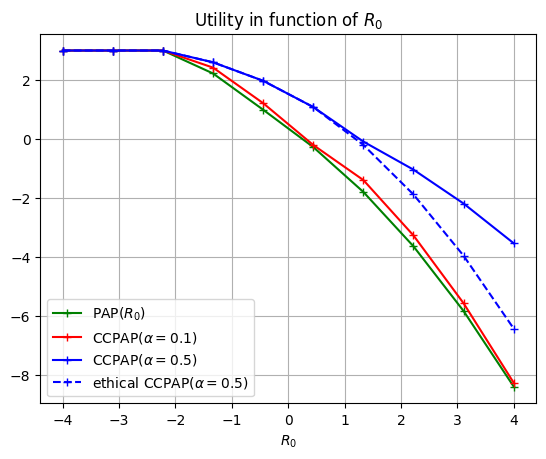

In [40]:
cc_pap_fun_mat = np.array([[ -cc_pap_res_mat_2[i][j].fun
    for j in range(len(alpha_list_2))] 
    for i in range(len(R0_list))])

ethical_cc_pap_fun_mat = np.array([[ -ethical_cc_pap_res_mat_2[i][j].fun
    for j in range(len(alpha_list_2))] 
    for i in range(len(R0_list))])

pap_fun_list = [-res.fun for res in pap_res_list]

colors = ["red","blue","green"]

plt.title("Utility in function of $R_0$")
plt.plot(R0_list,pap_fun_list,marker="+",label="PAP$(R_0)$",color="green")
plt.plot(R0_list,cc_pap_fun_mat[:,0],marker="+",label="CCPAP($\\alpha = 0.1$)",color="red")
plt.plot(R0_list,cc_pap_fun_mat[:,1],marker="+",label="CCPAP($\\alpha = 0.5$)",color="blue")
plt.plot(R0_list,ethical_cc_pap_fun_mat[:,1],marker="+",label="ethical CCPAP($\\alpha = 0.5$)",color="blue",ls="--")
plt.xlabel("$R_0$")
plt.legend()
plt.grid()
plt.show()

Let us plot the utility of the CC-PAP and the ethical CC-PAP with $R_0 = 3$, and different $\alpha$ values, to see when the ethical CC-PAP and the CC-PAP start to differ

In [41]:
alpha_list_x = [1e-3,5e-3,1e-2,5e-2] + list(np.linspace(0.1,0.9,10))
cc_pap_res_list = [cc_pap(alpha=alpha,R1=3,increasing_w=False) for alpha in alpha_list_x]
ethical_cc_pap_res_list = [cc_pap(alpha=alpha,R1=3,increasing_w=True) for alpha in alpha_list_x]

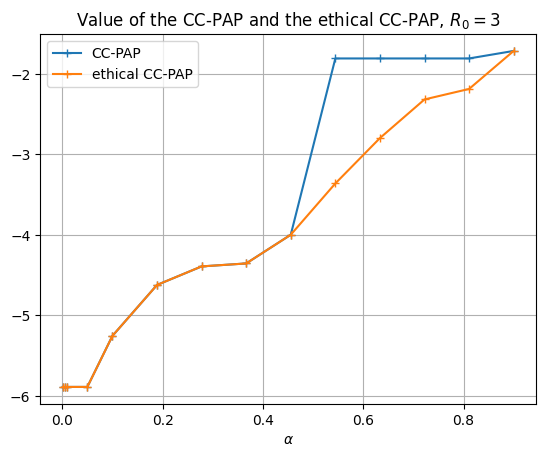

In [42]:
plt.title("Value of the CC-PAP and the ethical CC-PAP, $R_0 = 3$")

plt.plot(alpha_list_x,[-res.fun for res in cc_pap_res_list ],marker="+",label = "CC-PAP")
plt.plot(alpha_list_x,[-res.fun for res in ethical_cc_pap_res_list ],marker="+",label = "ethical CC-PAP")

plt.xlabel("$\\alpha$")

plt.legend()
plt.grid()
plt.show()

### High $R_0$

Now, let us solve the CC-PAP and the PAP for higher values of $R_0$, to study asymptotical properties.

In [43]:
R0_list_2 = np.linspace(0,100,10)
pap_res_list_3 = [pap_R0(loc_R0=r) for r in R0_list_2]

cc_pap_res_mat_3 = [[cc_pap(alpha=a,R1=r) for a in alpha_list] for r in R0_list_2]

7
[0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1]


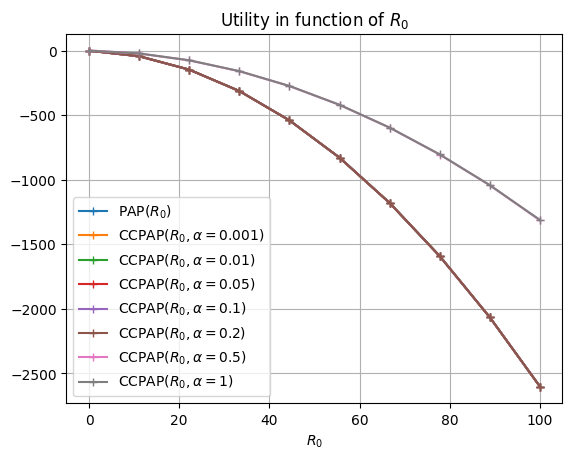

In [44]:
print(len(alpha_list))
print(alpha_list)

cc_pap_fun_mat = np.array([[ -cc_pap_res_mat_3[i][j].fun
    for j in range(len(alpha_list))] 
    for i in range(len(R0_list_2))])

pap_fun_list = [-res.fun for res in pap_res_list_3]

labels = [f"CCPAP$(R_0,\\alpha={a})$" for a in alpha_list]

plt.title("Utility in function of $R_0$")
plt.plot(R0_list_2,pap_fun_list,marker="+",label="PAP$(R_0)$")
plt.plot(R0_list_2,cc_pap_fun_mat,marker="+",label=labels)
plt.xlabel("$R_0$")
plt.legend()
plt.grid()
plt.show()

It appears that for $\alpha \in \{ 0.001, 0.01, 0.05, 0.1, 0.2 \}$, the asymptotic behavior of the CC-PAP is similar to the behavior of the PAP, and for $\alpha \in \{ 0.5, 1 \}$, the asymptote also seems parabolic. Let us fit these curves with degree 2 polynomials.

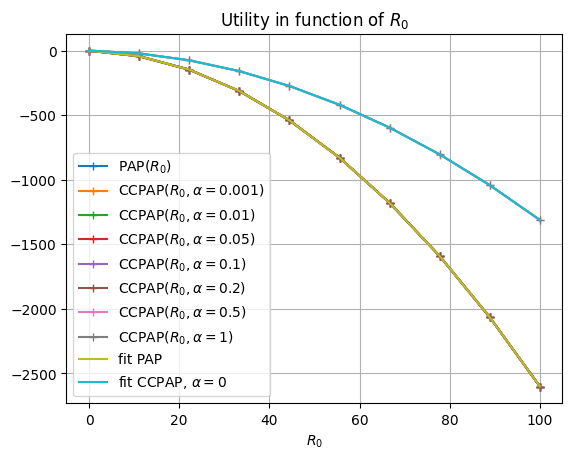

In [45]:
# fitting the coefficients

coeff_poly_pap = np.polyfit(R0_list_2,pap_fun_list,2)
coeff_poly_ccpap = np.polyfit(R0_list_2,cc_pap_fun_mat[:,-1],2)

# evaluating the polynomials in all R0 values

poly_fit_pap = np.poly1d(coeff_poly_pap)(R0_list_2)
poly_fit_ccpap = np.poly1d(coeff_poly_ccpap)(R0_list_2)

# plotting

labels = [f"CCPAP$(R_0,\\alpha={a})$" for a in alpha_list]

plt.title("Utility in function of $R_0$")
plt.plot(R0_list_2,pap_fun_list,marker="+",label="PAP$(R_0)$")
plt.plot(R0_list_2,cc_pap_fun_mat,marker="+",label=labels)

plt.plot(R0_list_2,poly_fit_pap,label="fit PAP")
plt.plot(R0_list_2,poly_fit_ccpap,label="fit CCPAP, $\\alpha=0$")

plt.xlabel("$R_0$")
plt.legend()
plt.grid()
plt.show()

In [46]:
print(f"Coefficients PAP fit")
print(coeff_poly_pap)
print()

print(f"Coefficients CC-PAP fit")
print(coeff_poly_ccpap)
print()

Coefficients PAP fit
[-0.24975671 -1.03245357 -0.00767495]

Coefficients CC-PAP fit
[-0.12504514 -0.6163173   1.58390643]



We recover the same equivalent as in section 2 for the PAP : $\frac{1}{4}(R_0)^2$, and we obtain an heuristic for the equivalent of the CC-PAP with parameter $\alpha \geq 0.5$ : $\frac{1}{8}(R_0)^2$

We have seen that between 1.3 and 4, the wages of the CC-PAP for $\alpha \in \{0.5, 1\}$ were sometimes non monotonous. Is that the case for bigger $R_0$ values ?

In [47]:
for i in range(len(R0_list_2)):
    for j in range(len(alpha_list)):
        d1,d2 = check_increase(cc_pap_res_mat_3[i][j].x)
        if (d1 < -1e-4) or (d2 < 0):
            print(f"R0 = {R0_list_2[i]}, alpha = {alpha_list[j]}")
            print(f"w1_t = {cc_pap_res_mat_3[i][j].x[0]}")
            print(f"w2_t = {cc_pap_res_mat_3[i][j].x[1]}")
            print(f"w3_t = {cc_pap_res_mat_3[i][j].x[2]}")
            print()

R0 = 0.0, alpha = 0.001
w1_t = 0.9989988510260877
w2_t = 0.998425371214895
w3_t = 1.9989999999985801

R0 = 0.0, alpha = 0.01
w1_t = 0.9899978784121177
w2_t = 0.9898936590482081
w3_t = 1.9900000000002245

R0 = 11.11111111111111, alpha = 0.2
w1_t = 5.624840520507691
w2_t = 6.861128366397747
w3_t = 6.861128366085783

R0 = 11.11111111111111, alpha = 0.5
w1_t = 0.0
w2_t = 6.805524774708273
w3_t = 0.9984501262505858

R0 = 11.11111111111111, alpha = 1
w1_t = 0.8697885493314496
w2_t = 6.7415848900758455
w3_t = 2.4648568236114364e-11

R0 = 22.22222222222222, alpha = 0.2
w1_t = 11.180203133034674
w2_t = 12.416684166480776
w3_t = 12.416684022040963

R0 = 22.22222222222222, alpha = 0.5
w1_t = 9.722005064684001e-12
w2_t = 12.361099439849646
w3_t = 0.999231115968778

R0 = 22.22222222222222, alpha = 1
w1_t = 1.265482529671434
w2_t = 12.316778526929717
w3_t = 1.6772972940553234e-10

R0 = 33.33333333333333, alpha = 0.5
w1_t = 2.1132073674739564e-10
w2_t = 17.916657340691035
w3_t = 0.9984174135686359

R

/tmp/ipykernel_23354/1630764533.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  increment_2 = (w3_t - w2_t) / np.abs(w3_t)


According to this code block, the optimal wages are often non-decreasing for $\alpha \in \{0,0.5\}$ and $R_0 \geq 10$.

Let us plot, for $\alpha = 0.5$, the value of the CC-PAP and the ethical CC-PAP

In [48]:
cc_pap_res_mat_4 = [[cc_pap(alpha=a,R1=r) for a in alpha_list_2] for r in R0_list_2]
ethical_cc_pap_res_mat_4 = [[cc_pap(alpha=a,R1=r,increasing_w=True) for a in alpha_list_2] for r in R0_list_2]

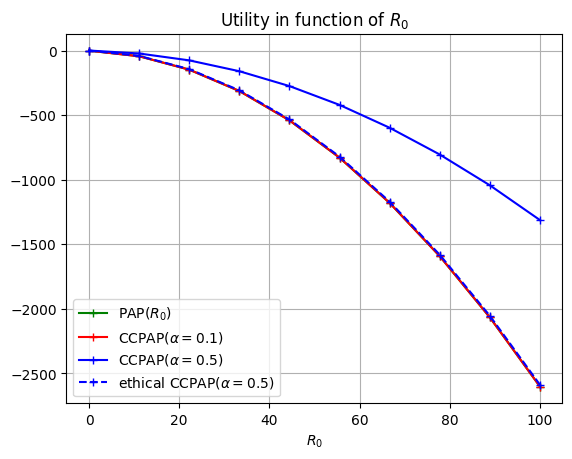

In [49]:
cc_pap_fun_mat = np.array([[ -cc_pap_res_mat_4[i][j].fun
    for j in range(len(alpha_list_2))] 
    for i in range(len(R0_list_2))])

ethical_cc_pap_fun_mat = np.array([[ -ethical_cc_pap_res_mat_4[i][j].fun
    for j in range(len(alpha_list_2))] 
    for i in range(len(R0_list_2))])

pap_fun_list = [-res.fun for res in pap_res_list_3]

labels_1 = [f"CCPAP$(R_0,\\alpha={a})$" for a in alpha_list_2]
labels_2 = [f"ethical CCPAP$(R_0,\\alpha={a})$" for a in alpha_list_2]
colors = ["red","blue","green"]

plt.title("Utility in function of $R_0$")
plt.plot(R0_list_2,pap_fun_list,marker="+",label="PAP$(R_0)$",color="green")
plt.plot(R0_list_2,cc_pap_fun_mat[:,0],marker="+",label="CCPAP($\\alpha = 0.1$)",color="red")
plt.plot(R0_list_2,cc_pap_fun_mat[:,1],marker="+",label="CCPAP($\\alpha = 0.5$)",color="blue")
plt.plot(R0_list_2,ethical_cc_pap_fun_mat[:,1],marker="+",label="ethical CCPAP($\\alpha = 0.5$)",color="blue",ls="--")
plt.xlabel("$R_0$")
plt.legend()
plt.grid()
plt.show()

We finish this notebook plotting the utility of the CC-PAP and the ethical CC-PAP with $R_0 = 80$, and different $\alpha$ values, to see when the ethical CC-PAP and the CC-PAP start to differ

In [50]:
alpha_list_x = [1e-3,5e-3,1e-2,5e-2] + list(np.linspace(0.1,0.9,10))
cc_pap_res_list = [cc_pap(alpha=alpha,R1=80,increasing_w=False) for alpha in alpha_list_x]
ethical_cc_pap_res_list = [cc_pap(alpha=alpha,R1=80,increasing_w=True) for alpha in alpha_list_x]

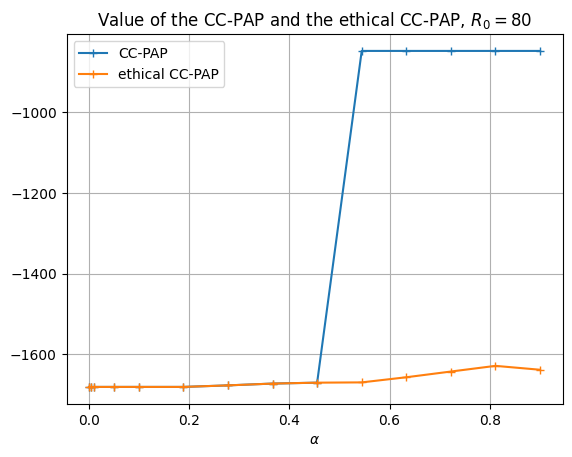

In [51]:
plt.title("Value of the CC-PAP and the ethical CC-PAP, $R_0 = 80$")

plt.plot(alpha_list_x,[-res.fun for res in cc_pap_res_list ],marker="+",label = "CC-PAP")
plt.plot(alpha_list_x,[-res.fun for res in ethical_cc_pap_res_list ],marker="+",label = "ethical CC-PAP")

plt.xlabel("$\\alpha$")

plt.legend()
plt.grid()
plt.show()